<a href="https://colab.research.google.com/github/mauricef/halite-iv-jax/blob/main/notebooks/07-random-agent-critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%pip install git+https://github.com/mauricef/halite-iv-jax.git@62c37f96f665449256622a622420da99e8a61342 \
    seaborn \
    dm-haiku \
    optax \
    kaggle-environments

  Cloning https://github.com/mauricef/halite-iv-jax.git (to revision 62c37f96f665449256622a622420da99e8a61342) to /tmp/pip-req-build-1h0bzv5d
  Running command git clone -q https://github.com/mauricef/halite-iv-jax.git /tmp/pip-req-build-1h0bzv5d
  Running command git rev-parse -q --verify 'sha^62c37f96f665449256622a622420da99e8a61342'
  Running command git fetch -q https://github.com/mauricef/halite-iv-jax.git 62c37f96f665449256622a622420da99e8a61342
     |████████████████████████████████| 1.2 MB 7.8 MB/s 
     |████████████████████████████████| 56 kB 3.4 MB/s 
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which i

# Random Agent Critic
We create a simple critic model which learns to predict the value (sum of discounted future rewards) for a given state. The model is trained through standard supervised learning using episodes generated by a random agent which is restricted to move a single ship. The reward is the change in single ship cargo per step.

In [7]:
%load_ext autoreload
%autoreload 2

import copy
from collections import namedtuple
import haiku as hk
from jax import random, jit, partial, vmap, value_and_grad, grad, lax, ops, nn
import jax.numpy as np
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns

from halite_jax import State, Cell, Episode, Trajectory
from halite_jax import tree_index, tree_batch
from halite_jax import net_present_value
from halite_jax import generate_episode
from halite_jax import Action
from halite_jax import make_config
from halite_jax import render_episode, render_state
from halite_jax import vmap_random
rng = random.PRNGKey(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading environment football failed: No module named 'gfootball'


## Scenario
We will create a very simple Halite scenario. A 5x5 board with a single player and a single ship. Every cell will start with a Halite value of 1. The ship will mine 100% (i.e. 1.) Halite and
we will set the regenRate to 0 so cells stay empty after a single mine action.

In [8]:
episode_steps = 50
board_size = 5
board_shape = (board_size, board_size)
cell_count = board_size ** 2
configuration = make_config(size=board_size, episodeSteps=episode_steps, regenRate=0., maxCellHalite=1., collectRate=1.)

initial_state = State(
    halite=np.zeros((1,)),
    step=np.array(0.),
    cells=Cell(
        owner=np.repeat(np.array([0, -1], int), np.array([1, 0]), total_repeat_length=cell_count).reshape(board_shape),
        halite=np.ones(board_shape),
        shipyard=np.zeros(board_shape, bool),
        ship=np.repeat(np.array([1, 0], bool), np.array([1, 0]), total_repeat_length=cell_count).reshape(board_shape),
        cargo=np.zeros(board_shape)
    )
)
render_state(configuration, initial_state)

## Agent
The agent will select an action at random either moving or mining, no converting to shipyard.

In [9]:
def random_move_agent(state, rng, player):
    return Action(
        ship=random.randint(rng, minval=0, maxval=5, shape=state.cells.ship.shape),
        shipyard=np.zeros_like(state.cells.shipyard))

agents = [random_move_agent]
generate_episode_for_scenario = jit(partial(generate_episode, configuration, agents, initial_state))

In [10]:
rng, r = random.split(rng)
episode = generate_episode_for_scenario(r)
render_episode(configuration, episode)

## Trajectory
A trajectory is a single episode (states and actions) along with reward and value. The reward is the change in cargo per step and the value is the discounted value of future rewards until the end of the episode.

In [11]:
discount_rate = 1.

@jit
def generate_trajectory(rng):
    rng, r = random.split(rng)
    states, actions = generate_episode_for_scenario(r)
    cargo = np.sum(states.cells.cargo, (1, 2))
    rewards = np.diff(cargo)
    values = net_present_value(discount_rate, rewards)
    states = tree_index(states, ops.index[:-1])
    return Trajectory(Episode(states, actions), rewards, values)

In [12]:
rng, r = random.split(rng)
trajectory = generate_trajectory(r)
render_episode(configuration, trajectory.episode)

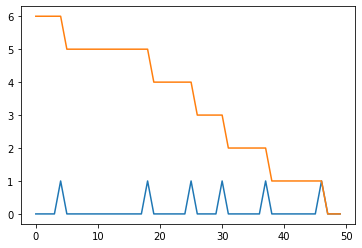

In [13]:
plt.plot(trajectory.reward)
plt.plot(trajectory.value)

## Training Data
Our training data is simply a batch of trajectories. This is a supervised learning exercise since the model we are learning (the critic model) does not influence the generation of training data. In other words, our agents actions doesn't depend on our model, there is no feedback loop between them.

In [14]:
batch_generate_trajectory = vmap_random(generate_trajectory)

In [15]:
training_episode_count = 4096
training_episode_per_batch = 64
training_data_num_batches = training_episode_count // training_episode_per_batch

rng, r = random.split(rng)
training_data = batch_generate_trajectory(r, batch_size=training_episode_count)
training_data = tree_map(np.concatenate, training_data) # flatten the episodes
training_data_batches = tree_batch(training_data, training_data_num_batches)

In [16]:
df = pd.DataFrame(data=dict(
    step=np.array(training_data.state.step, int),
    cargo=np.array(np.sum(training_data.state.cells.cargo, (1, 2)), int),
    value=np.array(training_data.value, int),
    halite=np.array(np.sum(training_data.state.cells.halite, (1, 2)), int),
    action=np.array(np.sum(training_data.action.ship, (1, 2)), int)
))
df['episode'] = df.index // 50
df

,step,cargo,value,halite,action,episode
0,0,0,9,25,4,0
1,1,0,9,25,0,0
2,2,1,8,24,1,0
3,3,1,8,24,2,0
4,4,1,8,24,1,0
...,...,...,...,...,...,...
204795,45,7,0,18,0,4095
204796,46,7,0,18,1,4095
204797,47,7,0,18,0,4095
204798,48,7,0,18,0,4095


The marginal distribution of the values

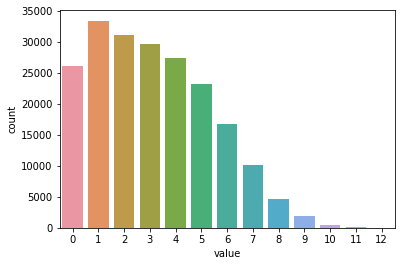

In [17]:
_ = sns.countplot(x='value', data=df)

The actions are uniformly distributed

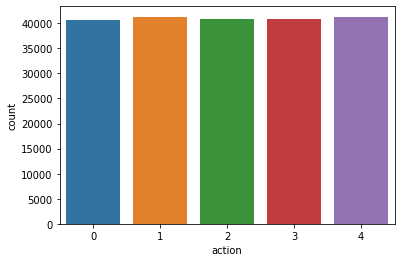

In [18]:
_ = sns.countplot(x='action', data=df)

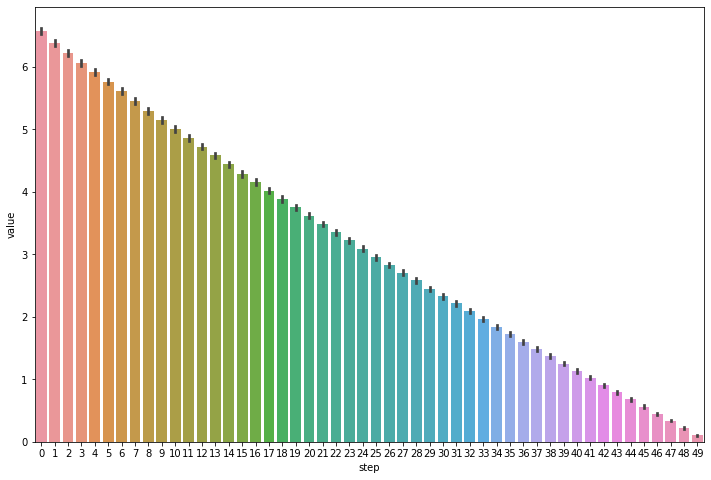

In [19]:
fig = plt.figure(figsize=(12,8))
mean_value_per_step = df.groupby('step').agg({'value': 'mean'})
_ = sns.barplot(x=df.step, y=df.value, data=df)

As the amount of board halite goes up, the value goes up and as the step goes down (meaning we have more steps remaining) the value goes up.

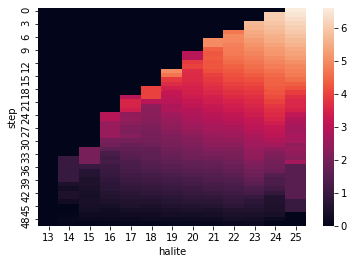

In [20]:
mean_value_dist = df.groupby(['step', 'halite']).agg({'value': 'mean'}).value
mean_value_dist = mean_value_dist.unstack().fillna(0)
_ = sns.heatmap(mean_value_dist)

The previous plot showed the mean values but it didn't indicate how common a given (step, halite) state was in our training data. Here we see that we start off at step zero with 25 halite and then the amount of halite decreases linearly as steps proceed but the distribution of halite becomes less certain as the agent performs its random walk/mine.

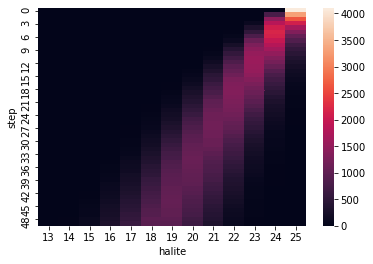

In [21]:
density_dist = df.groupby(['step', 'halite']).size()
density_dist = density_dist.unstack().fillna(0)
_ = sns.heatmap(density_dist)

## Training
We will train using optax and simple loop over our training data using l2 loss and evaluating using the mean absolute error.

In [22]:
num_batches = training_data_num_batches
num_epochs = 10
optimizer = optax.adam(learning_rate=1e-2)

In [23]:
@partial(jit, static_argnames=('model'))
def train(rng, model):
    def loss_fn(x, y, model_state):
        yp = vmap(partial(model.apply, model_state))(x)
        losses = optax.l2_loss(y, yp)
        return np.mean(losses)
    
    def train_batch(carry, i):
        model_state, opt_state = carry
        batch = tree_index(training_data_batches, i)
        loss_value, loss_grads = value_and_grad(partial(loss_fn, batch.state, batch.value))(model_state)
        model_updates, opt_state = optimizer.update(loss_grads, opt_state)
        model_state = optax.apply_updates(model_state, model_updates)
        return (model_state, opt_state), loss_value

    def train_epoch(carry, i):    
        rng, model_state, opt_state = carry
        batch_order = np.arange(num_batches)
        rng, r = random.split(rng)
        batch_order = random.permutation(r, batch_order)
        (model_state, opt_state), loss_value = lax.scan(train_batch, init=(model_state, opt_state), xs=batch_order)
        return (rng, model_state, opt_state), loss_value

    def train_model(rng, model_state, opt_state):
        return lax.scan(train_epoch, init=(rng, model_state, opt_state), xs=np.arange(num_epochs))
    
    rng, r = random.split(rng)
    model_state = model.init(r, initial_state)
    opt_state = optimizer.init(model_state)
    (_, model_state, opt_state), loss_values = train_model(rng, model_state, opt_state)
    loss_values = np.concatenate(loss_values)
    return model_state, opt_state, loss_values

In [26]:
@partial(jit, static_argnames=('model'))
def predict_values(model, model_state):
    return vmap(partial(model.apply, model_state))(training_data.state)

In [27]:
@hk.without_apply_rng
@hk.transform
def model_0(x):
    x = np.array([
        0.,
    ])
    return hk.Linear(1)(x)[0]

@hk.without_apply_rng
@hk.transform
def model_1(x):
    x = np.array([
        np.sum(x.cells.halite) / cell_count
    ])
    value = hk.Linear(1)(x)[0]
    return value

@hk.without_apply_rng
@hk.transform
def model_2(x):
    x = np.array([
        x.step / episode_steps,
    ])
    return hk.Linear(1)(x)[0]

@hk.without_apply_rng
@hk.transform
def model_3(x):
    x = np.array([
        x.step / episode_steps,
        np.sum(x.cells.halite) / cell_count
    ])
    value = hk.Linear(1)(x)[0]
    return value

@hk.without_apply_rng
@hk.transform
def model_4(x):
    x = np.array([
        x.step / episode_steps,
        np.sum(x.cells.halite) / cell_count
    ])
    value = hk.Linear(1)(x)[0]
    return np.exp(value)

In [28]:
models = [model_0, model_1, model_2, model_3, model_4]
num_models = len(models)
model_weights = []
model_losses = []
model_predicted_values = []
for i, model in enumerate(models):
    rng, r = random.split(rng)
    model_state, opt_state, loss_values = train(r, model)
    model_weights.append(model_state)
    model_losses.append(loss_values)
    model_predicted_values.append(predict_values(model, model_state))

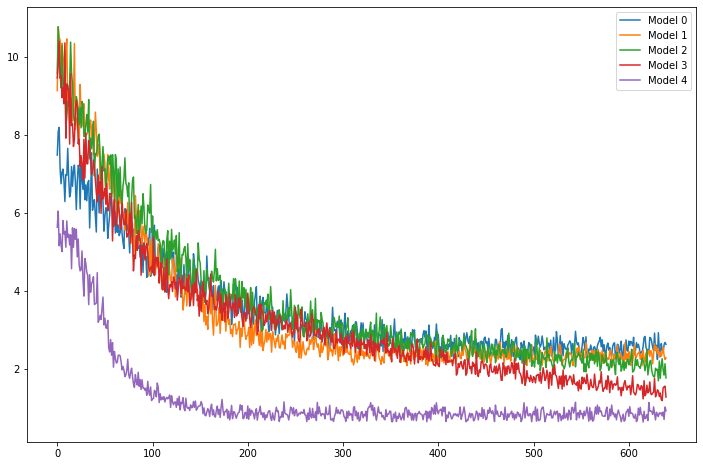

In [29]:
fig = plt.figure(figsize=(12,8))
for i in range(num_models):
    plt.plot(model_losses[i], label=f'Model {i}')
plt.legend()
plt.show()

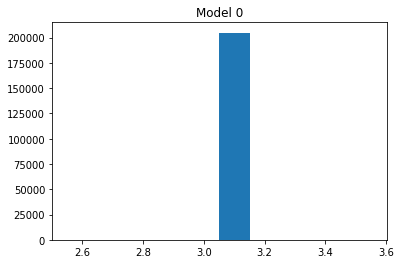

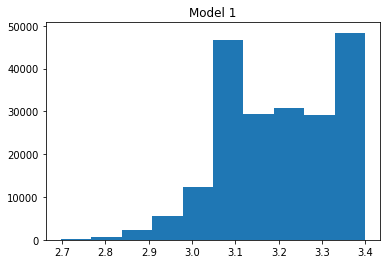

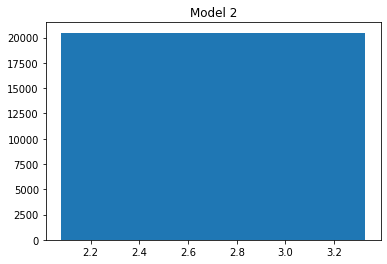

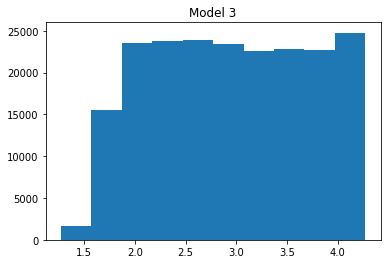

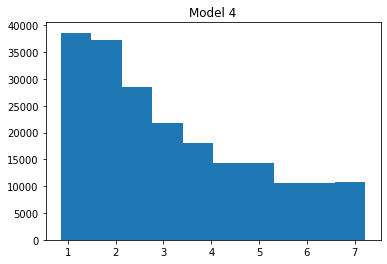

In [30]:
for i in range(num_models):
    plt.hist(model_predicted_values[i])
    plt.title(f'Model {i}')
    plt.show()

It looks like Model 4 has the distribution closest the the actual value distribution, the fact that the value is passed through `np.exp` seems to give the model a better ability to match the actual distribution shape.

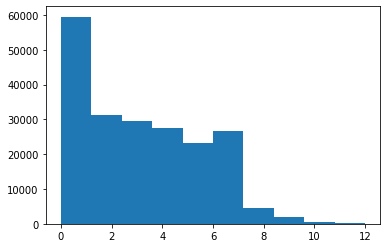

In [31]:
_ = plt.hist(df.value)